<a href="https://colab.research.google.com/github/GrantCanty/audio_classification/blob/main/classy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import glob
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
folder_path = '/content/gdrive/MyDrive/Colab Notebooks/audio classification/audio/'
files = glob.glob(folder_path + '*.wav')

In [ ]:
waveforms = []
sample_rates = []
file_names = []
labels = []

for file in files:
  audio, sample_rate = librosa.load(file, sr=None)
  waveforms.append(audio)
  sample_rates.append(sample_rate)
  file_name = file.split('/')[-1]

  label = file_name.split("_")[0]
  labels.append(label)
  file_names.append(file_name)

df = pd.DataFrame({
    'file_name': file_names,
    'label': labels,
    'waveform': waveforms,
    'sample_rate': sample_rates
})

In [ ]:
mfcc_features = [librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).mean(axis=1) for audio, sr in zip(waveforms, sample_rates)]

df['mfcc'] = mfcc_features
df.head()

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(


,file_name,label,waveform,sample_rate,mfcc
0,clap_1.wav,clap,"[4.0337714e-10, -0.015101412, -0.0304132, -0.0...",44100,"[-7.4256897, 67.46378, -61.57597, -15.109933, ..."
1,kick_1.wav,kick,"[1.1264456e-05, -6.2204446e-05, -0.00037539907...",44100,"[-353.08292, 86.52023, 54.048332, 34.678978, 2..."
2,kick_3.wav,kick,"[6.044118e-05, 0.00181752, 0.061917152, 0.1886...",44100,"[-387.37503, 66.08845, 37.45608, 31.711153, 26..."
3,snare_1.wav,snare,"[6.318092e-05, -0.00023055077, 0.00043845177, ...",44100,"[-15.422189, 82.31024, -87.41243, 6.775594, -2..."
4,hihat_1.wav,hihat,"[0.0015741985, 0.004734419, 0.00019104514, -0....",44100,"[-269.80807, -39.888287, -35.438705, 29.247242..."


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1372
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1623
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(


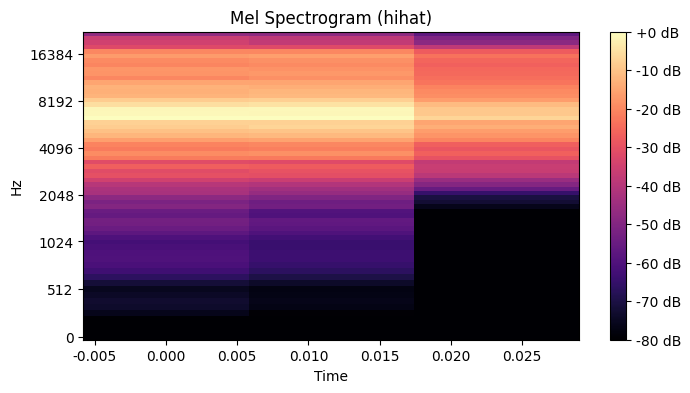

In [ ]:
def audio_to_mel_spectrogram(audio, sr, n_mels=64):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
    return mel_spec_db

# Convert all audio samples to spectrograms
spectrograms = [audio_to_mel_spectrogram(audio, sr) for audio, sr in zip(df["waveform"], df["sample_rate"])]

# Visualize an example
plt.figure(figsize=(8, 4))
librosa.display.specshow(spectrograms[0], sr=sample_rates[0], x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram ({df['label'][0]})")
plt.show()

In [ ]:
spectrograms = [np.expand_dims(s, axis=-1) for s in spectrograms]  # (time, freq, 1)


In [ ]:
# Resize spectrograms to 64x64
target_shape = (64, 64)
X = np.array([resize(tf.convert_to_tensor(s, dtype=tf.float32), target_shape).numpy() for s in spectrograms])

# Normalize pixel values (scale between 0 and 1)
X = X / np.max(X)

# Convert labels to numerical categories
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["label"])  # Convert "kick", "snare" → 0,1,2...
y = to_categorical(y)  # Convert to one-hot encoding

# Split into train & test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input (add channel dimension)
X_train = X_train[..., np.newaxis]  # (samples, 64, 64, 1)
X_test = X_test[..., np.newaxis]

In [ ]:


# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(y_train.shape[1], activation="softmax")  # Output layer
])

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2914 - loss: 19013738.0000 - val_accuracy: 0.5000 - val_loss: 3507846.0000
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4329 - loss: 12192212.0000 - val_accuracy: 0.6000 - val_loss: 5207551.0000
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5437 - loss: 7008348.0000 - val_accuracy: 0.7000 - val_loss: 994495.6250
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6546 - loss: 1540399.5000 - val_accuracy: 0.7000 - val_loss: 111924.3984
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7534 - loss: 343900.7500 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8252 - loss: 71539.8203 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9048 - loss: 5628.3672 - val_accuracy: 0.8000 - val_loss: 107562.8750
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc

In [ ]:
# Evaluate performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
print(f'all labels: {true_labels}')

# Convert back to original label names
predicted_names = label_encoder.inverse_transform(predicted_labels)
true_names = label_encoder.inverse_transform(true_labels)

print(true_names, predicted_names)

# Display first 5 predictions
for i in range(5):
    print(i)
    # print(f"Actual: {true_names[i]}, Predicted: {predicted_names[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Accuracy: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
all labels: [3 1 3 2 1 3 1 2 3 3]
['snare' 'hihat' 'snare' 'kick' 'hihat' 'snare' 'hihat' 'kick' 'snare'
 'snare'] ['snare' 'hihat' 'snare' 'kick' 'hihat' 'snare' 'hihat' 'kick' 'snare'
 'snare']
0
1
2
3
4
